In [25]:
import numpy as np
import networkx as nx
import timeit

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer

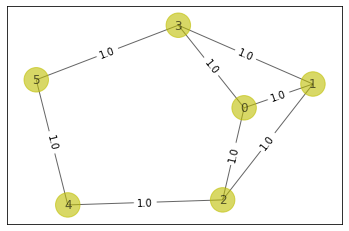

In [5]:
# Generating a graph of 6 nodes

n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 4, 1.0), (3, 5, 1.0), (4, 5, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["y" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.6, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [6]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]


case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 0, 0] cost = 4.0
case = [0, 1, 1, 0, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0, 0] cost = 3.0
case = [0, 0, 0, 1, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0] cost = 4.0
case = [0, 1, 0, 1, 0, 0] cost = 4.0
case = [1, 1, 0, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 1, 0, 0] cost = 6.0
case = [1, 0, 1, 1, 0, 0] cost = 5.0
case = [0, 1, 1, 1, 0, 0] cost = 5.0
case = [1, 1, 1, 1, 0, 0] cost = 2.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 5.0
case = [0, 1, 0, 0, 1, 0] cost = 5.0
case = [1, 1, 0, 0, 1, 0] cost = 6.0
case = [0, 0, 1, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0, 1, 0] cost = 4.0
case = [1, 1, 1, 0, 1, 0] cost = 3.0
case = [0, 0, 0, 1, 1, 0] cost = 5.0
case = [1, 0, 0, 1, 1, 0] cost = 6.0
case = [0, 1, 0, 1, 1, 0] cost = 6.0
c

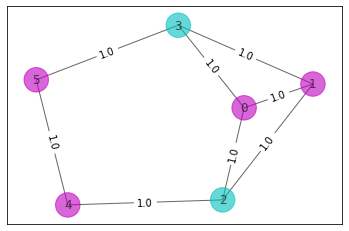

In [42]:
def brute():
    max_cost_brute = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))] # create reverse of binary combinations from 0 to 2**n to create every possible set
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j] * x[i] * (1 - x[j])
        if cost > max_cost_brute:
            max_cost_brute = cost
            xmax_brute = x
    
max_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))] # create reverse of binary combinations from 0 to 2**n to create every possible set
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if cost > max_cost_brute:
        max_cost_brute = cost
        xmax_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["m" if xmax_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xmax_brute) + " with cost = " + str(max_cost_brute))

time = timeit.timeit(brute, number = 1)
print(f"\nTime taken for brute force: {time}")

In [21]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 3 x_1 + 3 x_2 + 3 x_3 + 2 x_4 + 2 x_5 + [ - 4 x_0*x_1 - 4 x_0*x_2
      - 4 x_0*x_3 - 4 x_1*x_2 - 4 x_1*x_3 - 4 x_2*x_4 - 4 x_3*x_5 - 4 x_4*x_5
      ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [22]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -4.0
Ising Hamiltonian:
0.5 * IIIIZZ
+ 0.5 * IIIZIZ
+ 0.5 * IIIZZI
+ 0.5 * IIZIIZ
+ 0.5 * IIZIZI
+ 0.5 * IZIZII
+ 0.5 * ZIZIII
+ 0.5 * ZZIIII


In [39]:
# solving Quadratic Program using exact classical eigensolver

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())

def classical_eigen(): 
    result = exact.solve(qp)
    
result = exact.solve(qp)
print(result)
    
time = timeit.timeit(classical_eigen, number = 1)
print(f"\nTime taken for exact classical eigensolver force: {time}")

optimal function value: 6.0
optimal value: [0. 0. 1. 1. 0. 1.]
status: SUCCESS

Time taken for exact classical eigensolver force: 0.016265451908111572


energy: -2.0
max-cut objective: -6.0
solution: [0 0 1 1 0 1]
solution objective: 6.0


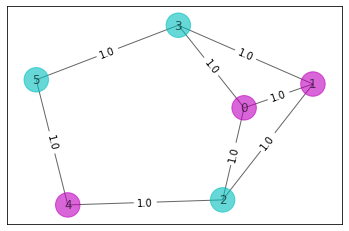

In [32]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["m" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [33]:
algorithm_globals.random_seed = 99
seed = 1010
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.995958462482359
time: 4.2608020305633545
max-cut objective: -5.995958462482359
solution: [0. 1. 0. 1. 1. 0.]
solution objective: 6.0

Time taken for VQE: 5.3587478790432215


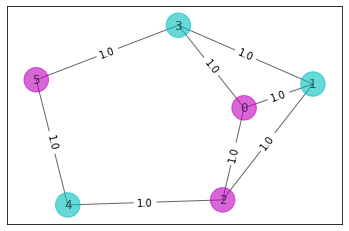

In [37]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
# def vqe_solve():
#     result = vqe.compute_minimum_eigenvalue(qubitOp)
# time = timeit.timeit(vqe_solve, number = 1)
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))
# print(f"\nTime taken for VQE: {time}")

# plot results
colors = ["m" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

optimal function value: 6.0
optimal value: [1. 1. 0. 0. 1. 0.]
status: SUCCESS


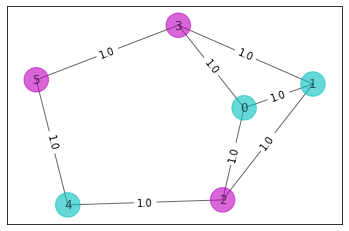

In [46]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ["m" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)